In [1]:
# CODE REFERENCES
# https://towardsdatascience.com/how-to-build-an-image-classifier-for-waste-sorting-6d11d3c9c478
# https://github.com/danny95333/Trash-Classification-based-on-CNN
from linear_classifier import *
from linear_svm import *
from softmax import *
import time
import random
import shutil
import re
import os
from pathlib import Path
from PIL import Image
import numpy as np
import imghdr
import matplotlib.pyplot as plt

In [2]:
# Declare the relative path to the PROCESSED trashnet data
# i.e. this path should go to "train", "test", "val" folders each of which 
# contain images for the train, test, and validation sets respectively.
dataRoot = "../../datasets/trashnet/data"

In [8]:
##########################
# DATA AUGMENTATION
# Loading the dataset into memory and applying transforms
# NOTE: May have to not use this for the baseline
##########################

# import torch
# from torchvision import transforms, datasets


# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }


# # Create an ImageFolder dataloader for the input data
# # See https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
# image_datasets = {x: datasets.ImageFolder(os.path.join(outDataPath, x),
#                                           data_transforms[x]) for x in ["train", "val"]}

# # Create DataLoader objects for each of the image datasets returned by ImageFolder
# # See https://pytorch.org/docs/stable/data.html
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
#                                               shuffle=True, num_workers=4) for x in ['train', 'val']}


# datasets_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# class_names = image_datasets['train'].classes

# print(datasets_sizes)
# print(class_names)
# print(image_datasets)

In [3]:
# TODO: Implement data loading manually as np arrays
##########################
# Loading the dataset into memory and applying transforms
##########################

# TODO: Preinitialize X etc. as zeros

def load_image( infilename ) :
    '''
    Helper function to manually load in images. Accepts image path infilename 
    and returns the numpy array representation of the image data
    (Need final X to be of dims (N, H, W, D))
    '''
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

# Load the training data
arrayList = []
labelList = []
trainRoot = os.path.join(dataRoot, "train")
for c in os.listdir(os.path.join(trainRoot)):
    for item in os.listdir(os.path.join(trainRoot, c)):
        if imghdr.what(os.path.join(trainRoot, c, item)):
            # Convert the image to a numpy array
            data = load_image(os.path.join(trainRoot, c, item))
            # Add to the array which we will stack at the end to form X
            arrayList.append(data)
            # Add label to array for Y
            labelList.append(c)
X_train = np.stack(tuple(arrayList))
y_train = np.array(labelList)
        
            
# Load the validation data
arrayList = []
labelList = []
valRoot = os.path.join(dataRoot, "val")
for c in os.listdir(os.path.join(valRoot)):
    for item in os.listdir(os.path.join(valRoot, c)):
        if imghdr.what(os.path.join(valRoot, c, item)):
            # Convert the image to a numpy array
            data = load_image(os.path.join(valRoot, c, item))
            # Add to the array which we will stack at the end to form X
            arrayList.append(data)
            # Add label to array for Y
            labelList.append(c)
X_val = np.stack(tuple(arrayList))
y_val = np.array(labelList)

# Load the test data
arrayList = []
labelList = []
testRoot = os.path.join(dataRoot, "test")
for item in os.listdir(testRoot):
    if imghdr.what(os.path.join(testRoot, item)):
        # Produce label from filename
        ########
        # TODO: Go back to dataloader and change it so we bucket test data into the same 
        # subfolder structure as train and val data
        ########
        c = os.path.splitext(re.sub("[0-9]+", "", item))[0]
        data = load_image(os.path.join(testRoot, item))
        arrayList.append(data)
        labelList.append(c)
X_test = np.stack(tuple(arrayList))
y_test = np.array(labelList)


In [4]:
# Flatten X matrices down for SVM classification
imageDim = 384*512*3

X_train = X_train.reshape((X_train.shape[0], imageDim))
X_val = X_val.reshape((X_val.shape[0], imageDim))
X_test = X_test.reshape((X_test.shape[0], imageDim))

In [5]:
# Sanity check dimensions
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1549, 589824)
(1549,)
(950, 589824)
(950,)
(970, 589824)
(970,)


[205.03873467 195.42414461 188.85409942 205.09038089 195.50677857
 188.95287282 205.00322789 195.46029697 188.90316333 204.8373144 ]


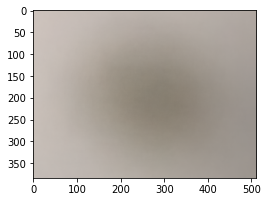

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((384,512,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train = X_train.astype(float) - mean_image
X_val = X_val.astype(float) - mean_image
X_test = X_test.astype(float) - mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(1549, 589825) (950, 589825) (970, 589825)


In [9]:
# Encode the class labels
from sklearn.preprocessing import LabelEncoder
classes = ["cardboard", "compost", "glass", "metal", "paper", "plastic", "trash"]
le = LabelEncoder()
le.fit(classes)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [10]:
# TRAIN THE MODEL
svm = LinearSVM()
tic = time.time()
print("Training model with {} rows of training data".format(X_train.shape[0]))
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('Training Complete. That took %fs' % (toc - tic))

Training model with 1549 rows of training data
iteration 0 / 1500: loss 51758.970565
iteration 100 / 1500: loss 18950.350247
iteration 200 / 1500: loss 6955.128668
iteration 300 / 1500: loss 2559.567971
iteration 400 / 1500: loss 944.906624
iteration 500 / 1500: loss 345.842202
iteration 600 / 1500: loss 136.435954
iteration 700 / 1500: loss 48.787233
iteration 800 / 1500: loss 27.078610
iteration 900 / 1500: loss 10.775324
iteration 1000 / 1500: loss 4.603236
iteration 1100 / 1500: loss 3.412914
iteration 1200 / 1500: loss 4.076586
iteration 1300 / 1500: loss 3.812797
iteration 1400 / 1500: loss 2.569621
Training Complete. That took 1143.433850s


In [12]:
# Validation set accuracy
y_val_pred = svm.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print('Baseline validation set accuracy is %f' % val_accuracy)

Baseline validation set accuracy is 0.424211


In [ ]:
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(384, 512, 3, len(classes))
w_min, w_max = np.min(w), np.max(w)
for i in range(len(classes)):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])